# Models Notebook

This notebook serves as a guide to the models we developed for this project. We have organized the implementation of these models into several Python scripts, each located in the `models` directory. Below is the structure of this directory:

```plaintext
project_root/
├── models/
    ├── mobilenet_v1.py
    ├── mobilenet_v2.py
    ├── se_net.py
    └── utils.py
```

**Overview**:

* `mobilenet_v1.py`: This script contains the implementation of MobileNetV1. It includes the architectural components such as standard convolutional blocks and depthwise separable convolutions.
* `mobilenet_v2.py`: This script contains the implementation of MobileNetV2. It includes the architectural components such as inverted residual bottlenecks.
* `se_net.py`: This script contains the implementation of both MobileNetV1 and MobileNetV2 enhanced with Squeeze-and-Exitation blocks.
* `utils.py`: This script contains utility functions to support model analysis, including functions to plot and save training history, and a function to compute FLOPs.

## Envirnoment Setup

Here we install and import all the necessary libraries. We mount the drive and use the `cd` command to navigate to the project directory.

In [1]:
import os
import tensorflow as tf
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Final_Project/'

/content/drive/.shortcut-targets-by-id/1wKqUB_Y6S42933NPubmLzrmazNFHNQsp/Final_Project


# MobileNetV1

The model we started with is MobileNetV1. In the diagram below, inspired from the offical paper [Howard 2017], we have detailed the architecture and all its components to facilitate its implementation.

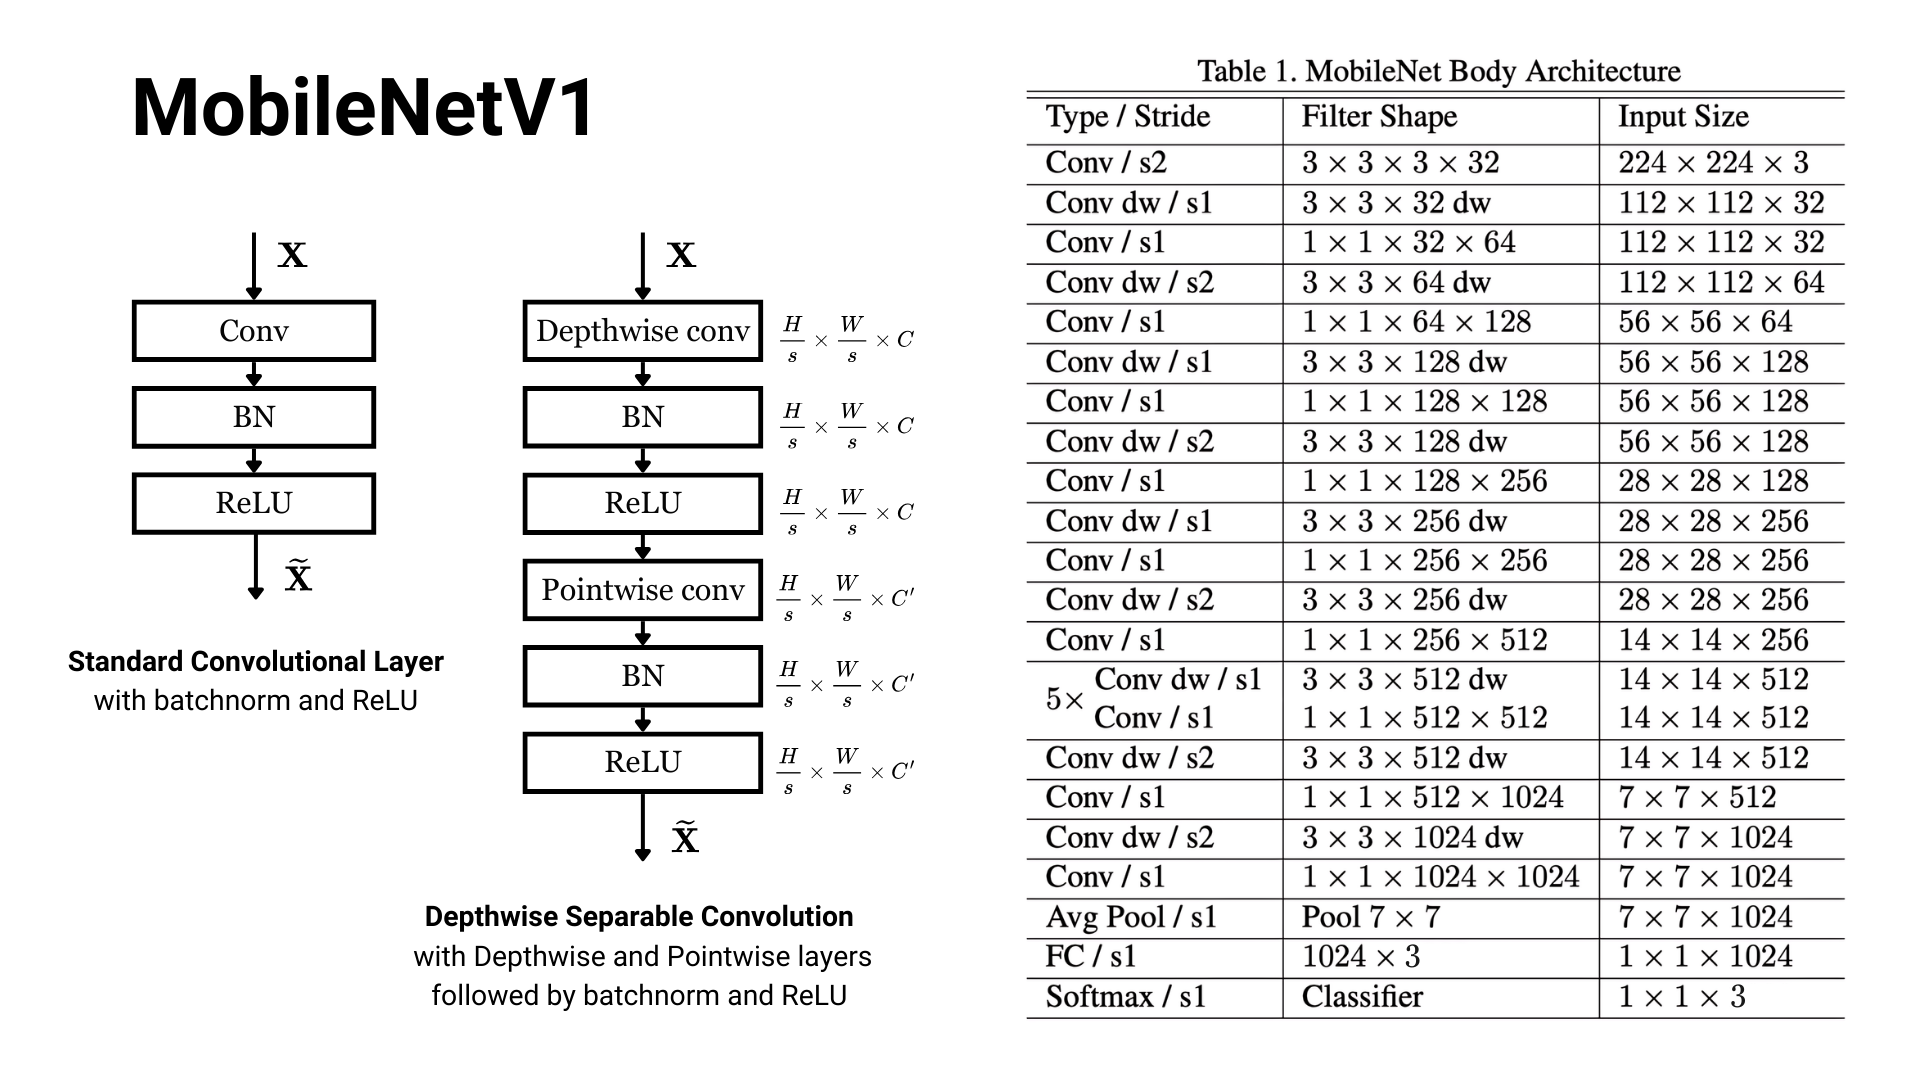

Implementation of the first convolutional block and the depthwise separable convolution block

In [ ]:
def conv_block(X, filters=32, kernel_size=(3,3), strides=(2,2), alpha=1.0, id="1"):
    '''Standard Convolution'''

    # First Conv
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=kernel_size, strides=strides, padding='same', name=f'conv_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_{id}_relu')(X)

    return X

def depthwise_conv_block(X, filters, strides=(1,1), alpha=1.0, id=None):
    '''Depthwise Separable Convolution'''

    # Depth-Wise Convolution
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same', name=f'conv_dw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_dw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_dw_{id}_relu')(X)

    # Point-Wise Convolution
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=(1,1), name=f'conv_pw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_pw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_pw_{id}_relu')(X)

    return X

In [ ]:
X = tf.random.uniform(shape=(1, 112, 112, 32), dtype=tf.float32)
depthwise_conv_block(X, filters=64, strides=(2,2)).shape

TensorShape([1, 56, 56, 64])

**MobileNetV1 architecture implementation**.

In this implementation, we have included the width multiplier (α) in order to allow the exploration different configurations of the model in experiments.

In [ ]:
def mobilenet_v1(input_shape, include_top=True, alpha=1.0, classes=3):
    '''Implementation of MobileNetV1 architecture'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, 32, (3,3), (2,2), alpha=alpha, id="1")
    X = depthwise_conv_block(X, 64, (1,1), alpha, id=1)

    X = depthwise_conv_block(X, 128, (2,2), alpha, id=2)
    X = depthwise_conv_block(X, 128, (1,1), alpha, id=3)

    X = depthwise_conv_block(X, 256, (2,2), alpha, id=4)
    X = depthwise_conv_block(X, 256, (1,1), alpha, id=5)

    X = depthwise_conv_block(X, 512, (2,2), alpha, id=6)
    for i in range(5):
        X = depthwise_conv_block(X, 512, (1,1), alpha, id=7+i)

    X = depthwise_conv_block(X, 1024, (2,2), alpha, id=12)
    X = depthwise_conv_block(X, 1024, (1,1), alpha, id=13)
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='mobilenet_v1')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)

    return tf.keras.models.Model(X_input, X, name='mobilenet_v1')

In [ ]:
model = mobilenet_v1(input_shape=(224,224,3), include_top=True)

print(f"Output Shape: {model.output_shape}")
print(f"Total params: {model.count_params()}")
#model.summary()

Output Shape: (None, 3)
Total params: 3242883


# MobileNetV2

We continued with MobileNetV2. Below is a diagram inspired from the official paper [Sandler 2019] that we realized to streamline the implementation of the model.

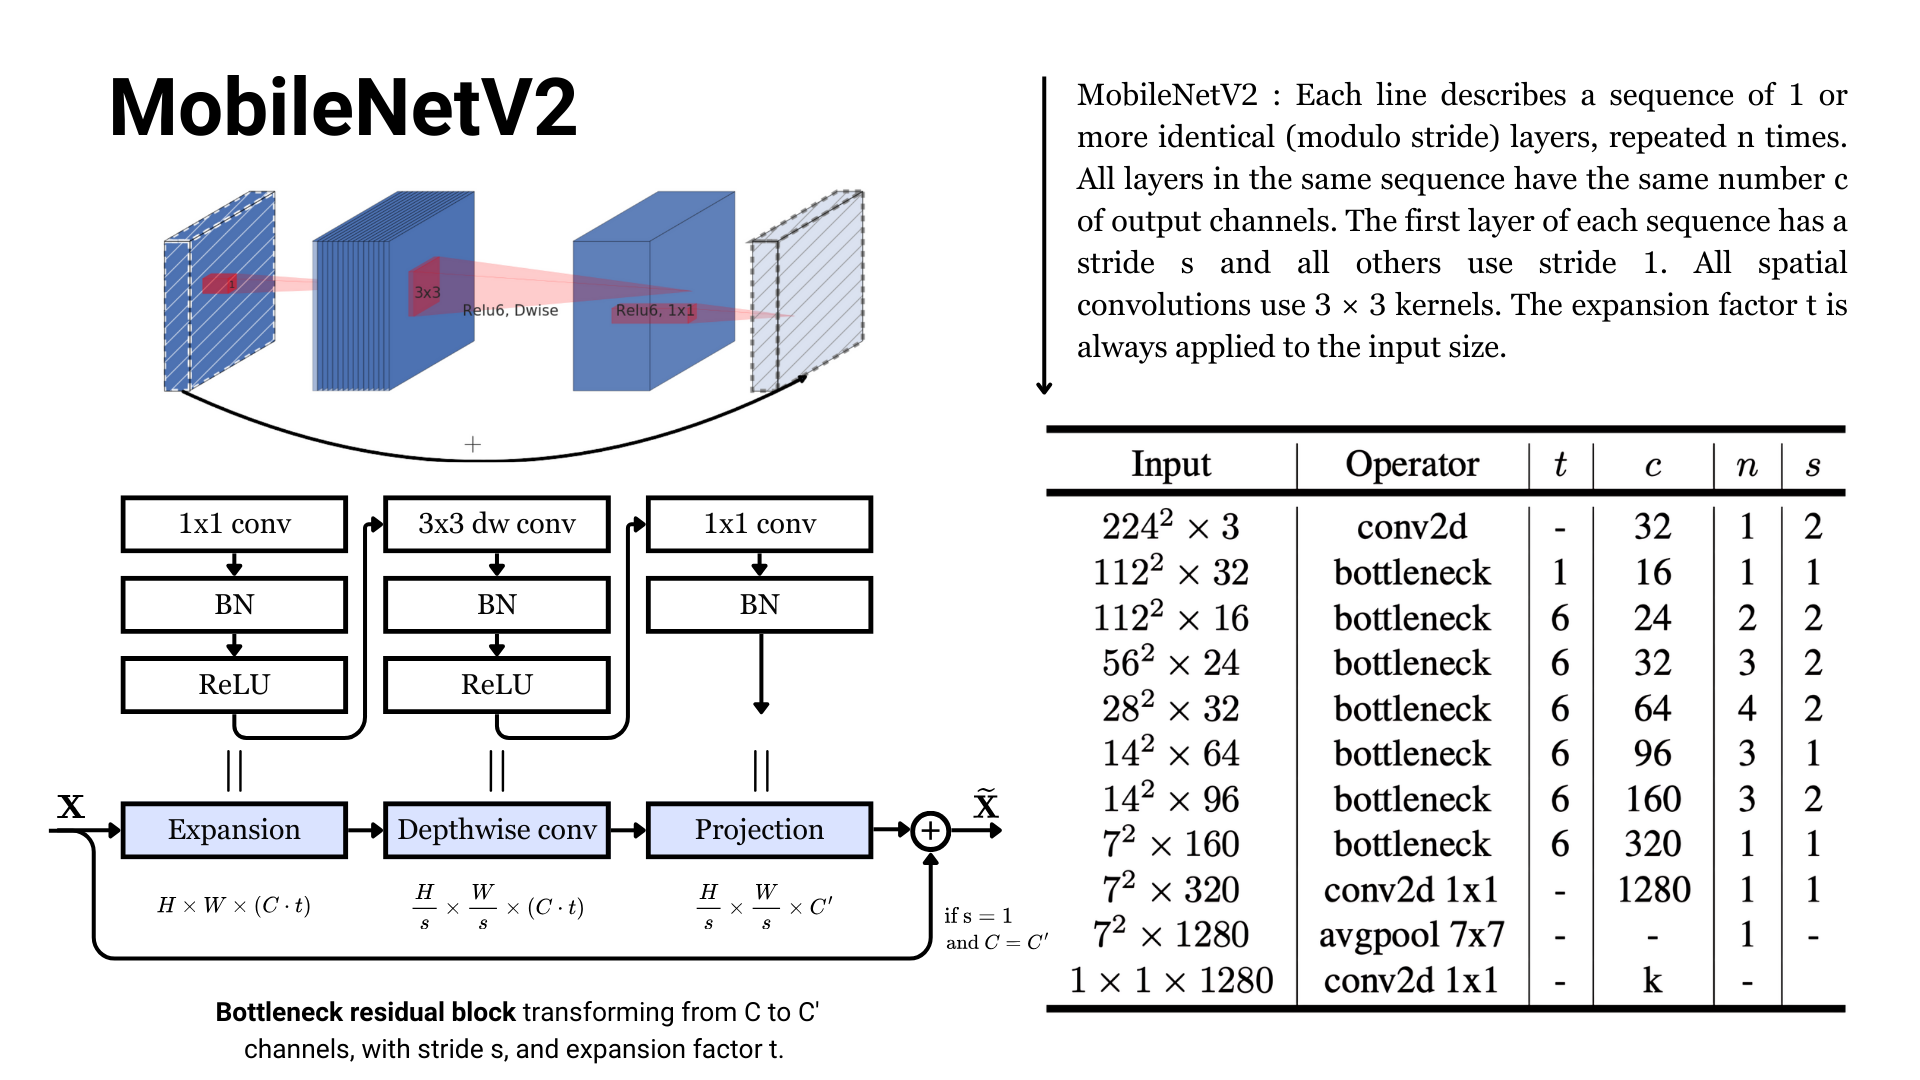

In [ ]:
def bottleneck(input, expansion, stride, alpha, filters, block_id):
    """Bottleneck residual block."""

    # Number of input channels
    k = input.shape[-1]

    # Expansion
    X = tf.keras.layers.Conv2D(filters=(expansion*k), kernel_size=(1,1), strides=(1,1), padding='same', name=f"expansion_{block_id}")(input)
    X = tf.keras.layers.BatchNormalization(name=f"expansion_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"expansion_{block_id}_relu")(X)

    # Depthwise convolution
    X = tf.keras.layers.DepthwiseConv2D((3,3), strides=stride, padding='same', name=f"conv_dw_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"conv_dw_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"conv_dw_{block_id}_relu")(X)

    # Projection
    X = tf.keras.layers.Conv2D(filters=int(filters * alpha), kernel_size=(1,1), strides=(1,1), padding='same', name=f"projection_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"projection_{block_id}_bn")(X)

    if k == X.shape[-1] and stride == (1,1):
        X = tf.keras.layers.Add(name=f"shortcut_{block_id}")([X, input])

    return X


In [ ]:
X = tf.random.uniform(shape=(1, 112, 112, 24), dtype=tf.float32)
bottleneck(X, 1, (1,1), 1.0, 24, '1').shape

TensorShape([1, 112, 112, 24])

In [ ]:
def mobilenet_v2(input_shape, include_top=True, alpha=1.0, classes=3):
    '''Implementation of MobileNetV2 architecture'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, filters=32, kernel_size=(3,3), strides=(2,2), alpha=alpha, id="1")

    X = bottleneck(input=X, expansion=1, stride=1, alpha=alpha, filters=16, block_id="1")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=24, block_id="2")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=24, block_id="3")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=32, block_id="4")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="5")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="6")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=64, block_id="7")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="8")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="9")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="10")

    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="11")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="12")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="13")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=160, block_id="14")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=160, block_id="15")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=160, block_id="16")

    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=320, block_id="17")

    X = conv_block(X, filters=1280, kernel_size=(1,1), strides=(1,1), alpha=alpha, id="2")
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='mobilenet_v2')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)
    return tf.keras.models.Model(X_input, X, name='mobilenet_v2')

In [ ]:
model = mobilenet_v2(input_shape=(224,224,3), include_top=True)

print(f"Output Shape: {model.output_shape}")
print(f"Total params: {model.count_params()}")
#model.summary()

Output Shape: (None, 3)
Total params: 2280067


# SE-Enhanced Architectures

Aiming to enhance the baseline models, we implemented the Squeeze-and-Excitation block following the diagram shown below, extracted from the paper [Hu 2018]. Subsequently, we integrated this channel attention mechanism into both architectures, resulting in two new models that we named SE-MobileNetV1 and SE-MobileNetV2.

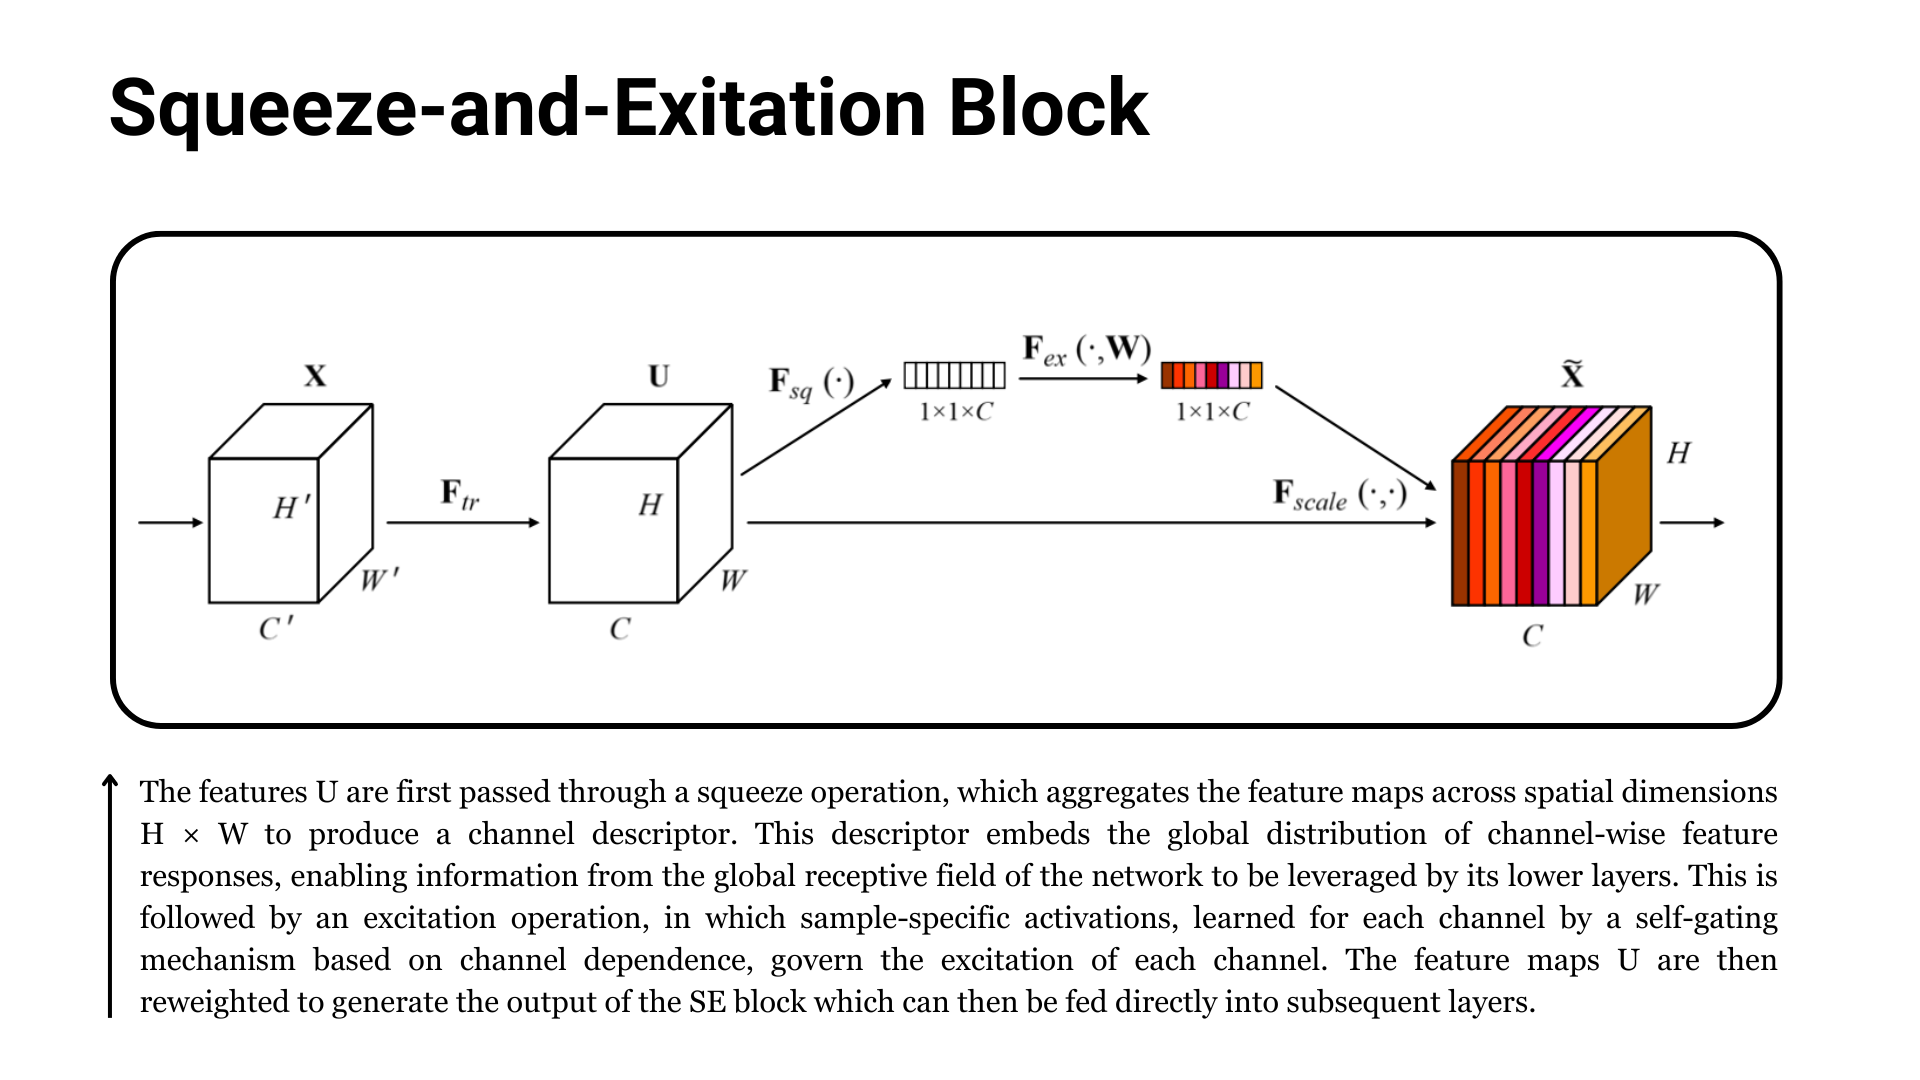

In [ ]:
def se_block(input, reduction_ratio, id):
    '''Squeeze-and-Exitation Block.'''

    c = input.shape[-1]

    # Squeeze
    X = tf.keras.layers.GlobalAveragePooling2D(name=f"se_{id}_avg_pool")(input)
    X = tf.keras.layers.Reshape((1, 1, c))(X)

    # Excitation
    X = tf.keras.layers.Dense(units=(c // reduction_ratio), activation="relu", use_bias=False, name=f"fc1_{id}")(X)
    X = tf.keras.layers.Dense(units=c, activation="sigmoid", use_bias=False, name=f"fc2_{id}")(X)

    return tf.keras.layers.Multiply(name=f"gate_{id}")([input, X])

In [ ]:
X = tf.random.uniform((1, 112, 112, 32))
se_block(X, 16, '1').shape

TensorShape([1, 112, 112, 32])

## SE-MobileNetV1

In MobileNetV1, SE blocks were added after the depthwise separable convolution, as shown in Figure, following the approach presented in the original paper [Hu 2018]. This method treats the depthwise separable block as a single unit and applies the SE modulation to the entire output of the block. We have introduced a boolean parameter `se` to toggle the inclusion of the SE block, allowing for flexible model configuration.

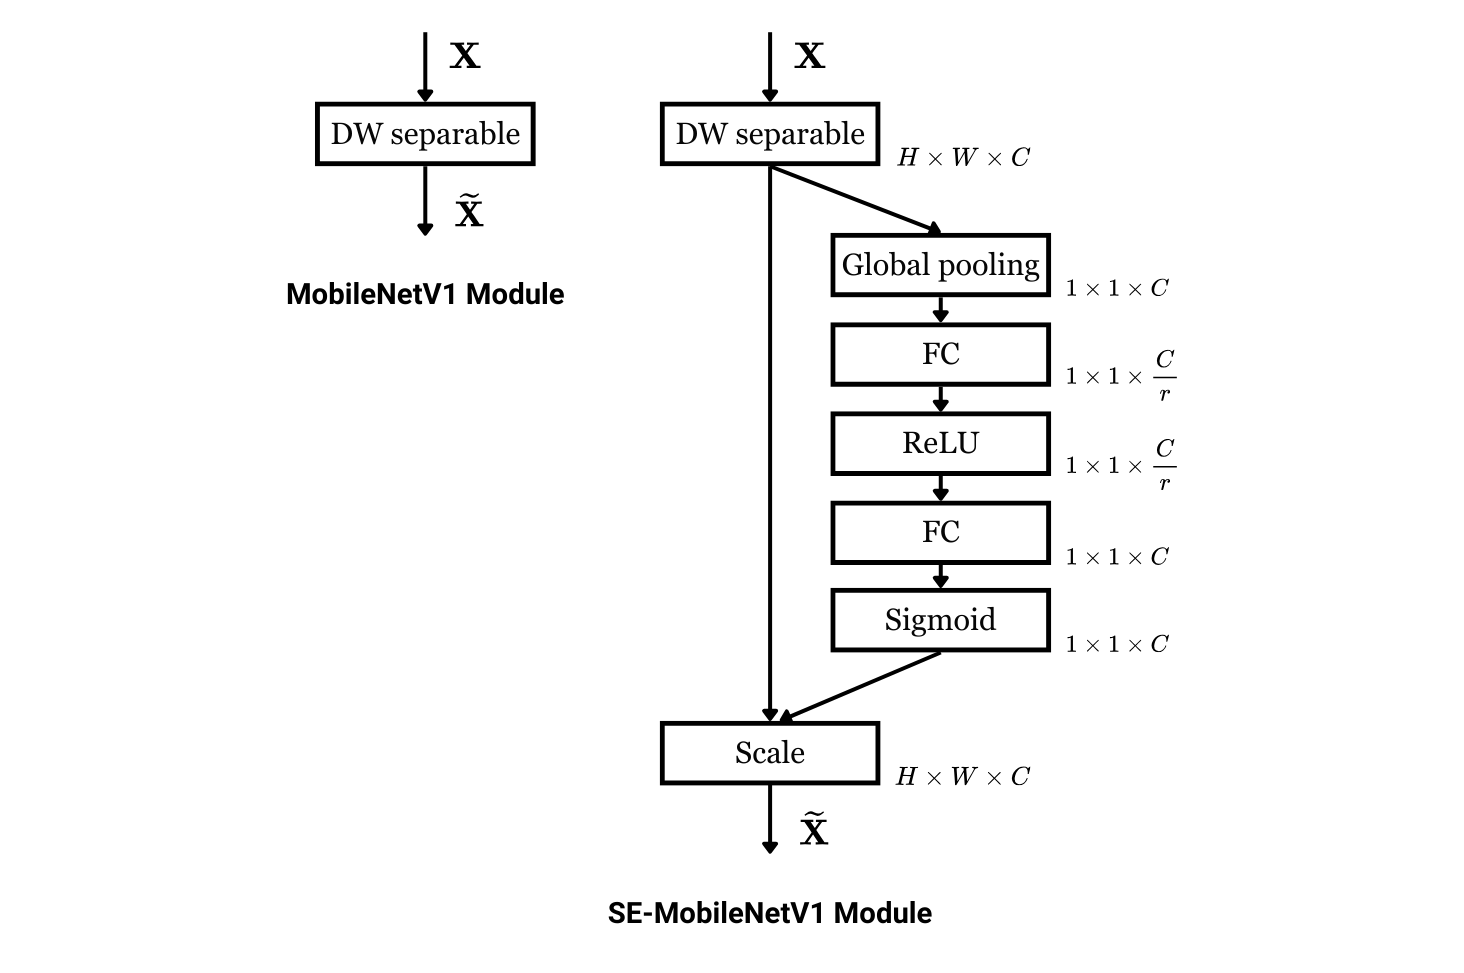

In [ ]:
def se_depthwise_conv_block(input, filters, strides=(1,1), alpha=1.0, reduction_ratio=16, se=False, id=None):
    '''Depthwise Separable Convolution with Squeeze-and-Exitation'''

    k = input.shape[-1]

    # Depth-Wise Convolution
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same', name=f'conv_dw_{id}')(input)
    X = tf.keras.layers.BatchNormalization(name=f'conv_dw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_dw_{id}_relu')(X)

    # Point-Wise Convolution
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=(1,1), name=f'conv_pw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_pw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_pw_{id}_relu')(X)

    # SE Block
    if se:
        X = se_block(X, reduction_ratio, id=id)

    return X

In [ ]:
def se_mobilenet_v1(input_shape, reduction_ratio=16, include_top=True, alpha=1.0, classes=3):
    '''MobileNetV1 enhanced with Squeeze-and-Exitation blocks'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, 32, (3,3), (2,2), alpha, id=1)
    X = se_depthwise_conv_block(X, 64, (1,1), alpha, reduction_ratio, se=False, id=1)

    X = se_depthwise_conv_block(X, 128, (2,2), alpha, reduction_ratio, se=False, id=2)
    X = se_depthwise_conv_block(X, 128, (1,1), alpha, reduction_ratio, se=False, id=3)

    X = se_depthwise_conv_block(X, 256, (2,2), alpha, reduction_ratio, se=False, id=4)
    X = se_depthwise_conv_block(X, 256, (1,1), alpha, reduction_ratio, se=False, id=5)

    X = se_depthwise_conv_block(X, 512, (2,2), alpha, reduction_ratio, se=True, id=6)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=7)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=8)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=9)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=10)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=11)

    X = se_depthwise_conv_block(X, 1024, (2,2), alpha, reduction_ratio, se=True, id=12)
    X = se_depthwise_conv_block(X, 1024, (1,1), alpha, reduction_ratio, se=True, id=13)
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='se_mobilenet_v1')

    #X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)

    return tf.keras.models.Model(X_input, X, name='se_mobilenet_v1')

In [ ]:
input_shape = (224,224,3)
print("MobileNetV1 params:"+' '*11, mobilenet_v1(input_shape).count_params())
for r in [32, 16, 8, 4]:
    print(f"SE-MobileNetV1 (r={r:02}) params: ", se_mobilenet_v1(input_shape, r).count_params())

MobileNetV1 params:            3242883
SE-MobileNetV1 (r=32) params:  3341187
SE-MobileNetV1 (r=16) params:  3439491
SE-MobileNetV1 (r=08) params:  3636099
SE-MobileNetV1 (r=04) params:  4029315


In [ ]:
mobilenet = tf.keras.models.load_model('./models/weights/1-MobileNetV1-224.keras')
se_mobilenet = se_mobilenet_v1(input_shape=(224,224,3))

for layer in se_mobilenet.layers:
    try:
        layer.set_weights(mobilenet.get_layer(layer.name).get_weights())
        print(f'Loaded weights for layer: {layer.name}')
    except ValueError:
        print(f'Skipping layer: {layer.name}')


Loaded weights for layer: input_layer
Loaded weights for layer: conv_1
Loaded weights for layer: conv_1_bn
Loaded weights for layer: conv_1_relu
Loaded weights for layer: conv_dw_1
Loaded weights for layer: conv_dw_1_bn
Loaded weights for layer: conv_dw_1_relu
Loaded weights for layer: conv_pw_1
Loaded weights for layer: conv_pw_1_bn
Loaded weights for layer: conv_pw_1_relu
Loaded weights for layer: conv_dw_2
Loaded weights for layer: conv_dw_2_bn
Loaded weights for layer: conv_dw_2_relu
Loaded weights for layer: conv_pw_2
Loaded weights for layer: conv_pw_2_bn
Loaded weights for layer: conv_pw_2_relu
Loaded weights for layer: conv_dw_3
Loaded weights for layer: conv_dw_3_bn
Loaded weights for layer: conv_dw_3_relu
Loaded weights for layer: conv_pw_3
Loaded weights for layer: conv_pw_3_bn
Loaded weights for layer: conv_pw_3_relu
Loaded weights for layer: conv_dw_4
Loaded weights for layer: conv_dw_4_bn
Loaded weights for layer: conv_dw_4_relu
Loaded weights for layer: conv_pw_4
Loaded 

## SE-MobileNetV2

In MobileNetV2, SE blocks were added after the depthwise convolution and before the final projection layer within the bottleneck block, following the approach proposed in the original paper for residual networks.

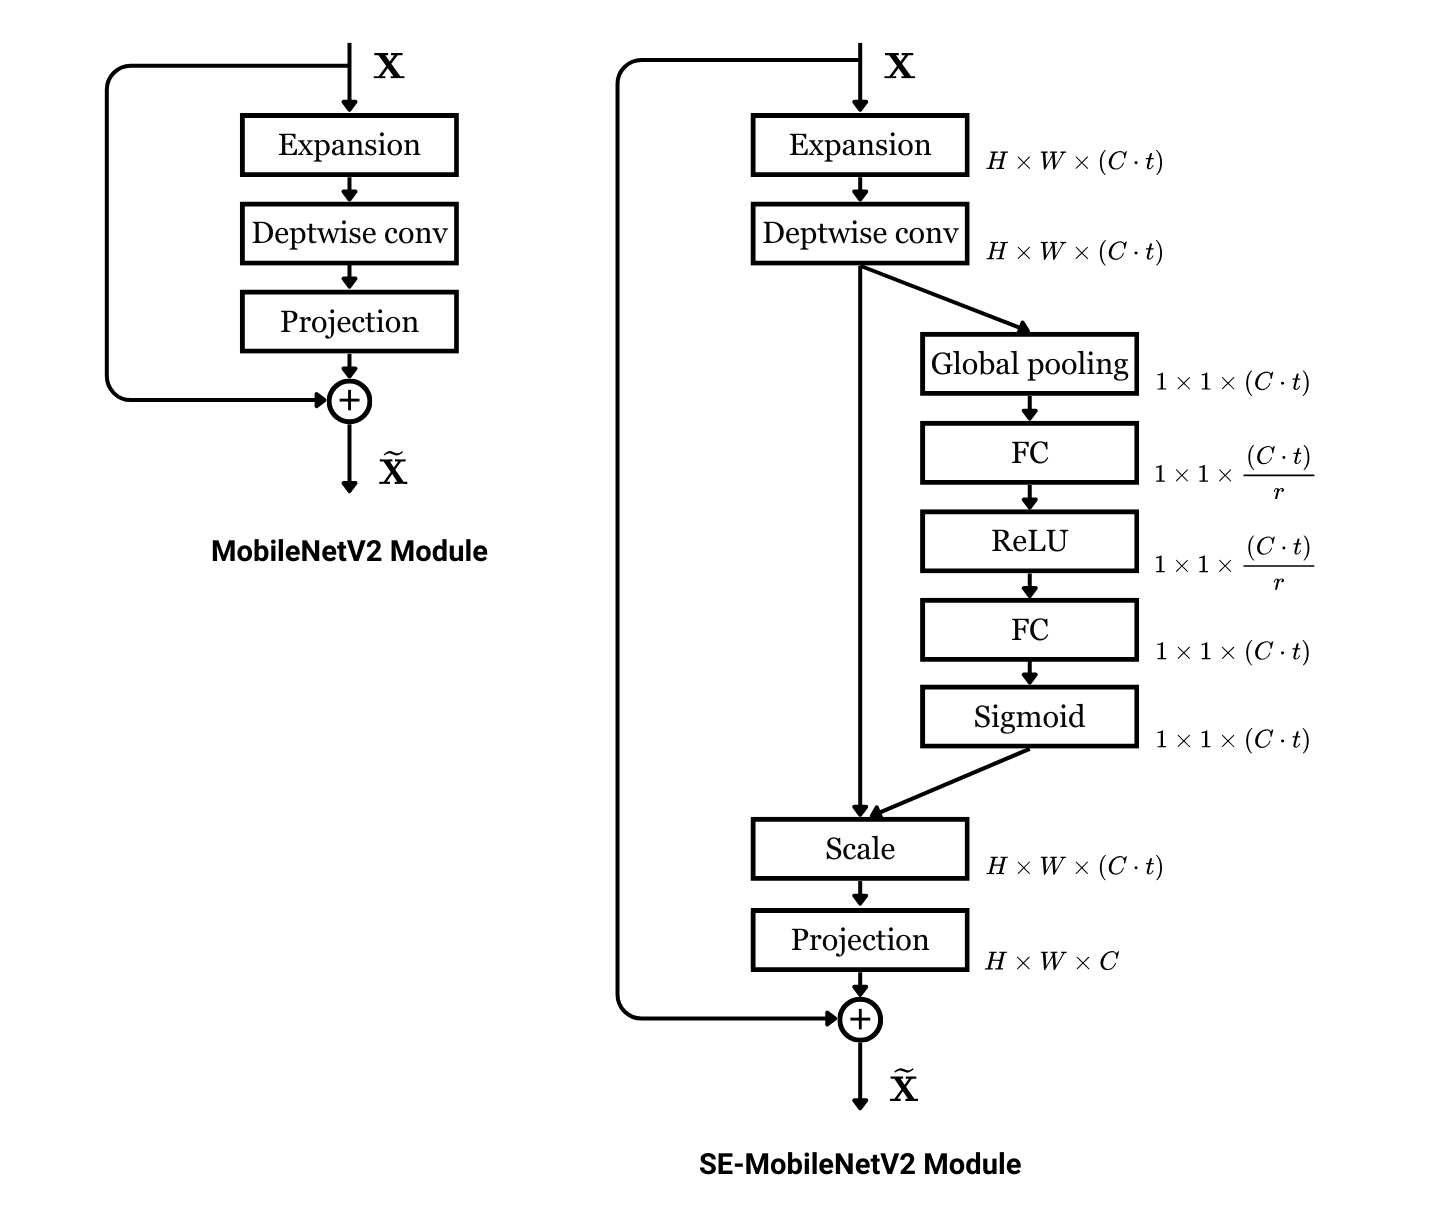

In [ ]:
def se_bottleneck(input, expansion, stride, alpha, filters, reduction_ratio, se=False, block_id=None):
    """Bottleneck residual block with Squeeze-and-Exitation."""

    # Number of input channels
    k = input.shape[-1]

    # Expansion
    X = tf.keras.layers.Conv2D(filters=(expansion * k), kernel_size=(1,1), strides=(1,1), name=f"expansion_{block_id}")(input)
    X = tf.keras.layers.BatchNormalization(name=f"expansion_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"expansion_{block_id}_relu")(X)

    # Depthwise convolution
    X = tf.keras.layers.DepthwiseConv2D((3,3), strides=stride, padding='same', name=f"conv_dw_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"conv_dw_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"conv_dw_{block_id}_relu")(X)

    # Squeeze-and-Excitation
    if se:
        X = se_block(X, reduction_ratio, id=block_id)

    # Projection
    X = tf.keras.layers.Conv2D(filters=int(filters * alpha), kernel_size=(1,1), strides=(1,1), name=f"projection_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"projection_{block_id}_bn")(X)

    # Shortcut connection
    if k == X.shape[-1] and stride == (1,1):
        X = tf.keras.layers.Add(name=f"shortcut_{block_id}")([X, input])

    return X

In [ ]:
def se_mobilenet_v2(input_shape, reduction_ratio=16, include_top=True, alpha=1.0, classes=3):
    '''MobileNetV2 with SE Blocks.'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, filters=32, kernel_size=(3,3), strides=(2,2), alpha=alpha, id="1")

    X = bottleneck(input=X, expansion=1, stride=1, alpha=alpha, filters=16, block_id="1")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=24, block_id="2")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=24, block_id="3")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=32, block_id="4")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="5")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="6")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=64, block_id="7")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="8")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="9")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="10")

    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, block_id="11")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, block_id="12")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, block_id="13")

    X = se_bottleneck(input=X, expansion=6, stride=(2,2), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, block_id="14")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, block_id="15")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, block_id="16")

    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=320, reduction_ratio=reduction_ratio, block_id="17")

    X = conv_block(X, filters=1280, kernel_size=(1,1), strides=(1,1), alpha=alpha, id="2")
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='se_mobilenet_v2')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)
    return tf.keras.models.Model(X_input, X, name='se_mobilenet_v2')

In [ ]:
input_shape = (224,224,3)
print("MobileNetV2 params:"+' '*11, mobilenet_v2(input_shape).count_params())
for r in [32, 16, 8, 4]:
    print(f"SE-MobileNetV2 (r={r:02}) params: ", se_mobilenet_v2(input_shape, r).count_params())

MobileNetV2 params:            2280067
SE-MobileNetV2 (r=32) params:  2285315
SE-MobileNetV2 (r=16) params:  2290611
SE-MobileNetV2 (r=08) params:  2301203
SE-MobileNetV2 (r=04) params:  2322339


# Utils

Here we define utility functions to support model analysis.

## FLOPs

Below, we define a function that calculates the FLOPS (Floating Point Operations) of a Keras model. This will be useful during the evaluation phase to compare the computational complexity of the models.

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def compute_flops(model):
    '''Compute the FLOPs of a Keras model.'''

    # Wrap the model in a tf.function to enable concrete function extraction
    model_func = tf.function(lambda x: model(x))

    # Create a concrete function from the model with a specific input shape
    concrete_func = model_func.get_concrete_function(tf.TensorSpec([1] + list(model.input[0].shape[1:]), model.input[0].dtype))

    # Convert the concrete function into a frozen graph (i.e., all variables converted to constants)
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    # Set up the RunMetadata object to store profiling data
    run_meta = tf.compat.v1.RunMetadata()

    # Set the options for profiling to count the floating point operations (FLOPs)
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    # Profile the frozen graph to compute the total number of FLOPs
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

In [ ]:
model = tf.keras.models.load_model('./models/weights/0.25-MobileNetV1-224_.keras')
compute_flops(model) // 2*1e-6

42.680529

## Training History

Below, we define functions to save and visualize the training history of the model.

In [ ]:
import json

def save_history_as_json(history, file_path):
    history_dict = history.history
    with open(file_path, 'w') as f:
        json.dump(history_dict, f)
    print(f"History saved as {file_path}")

Figure saved as ./models/figures/convergence.pdf


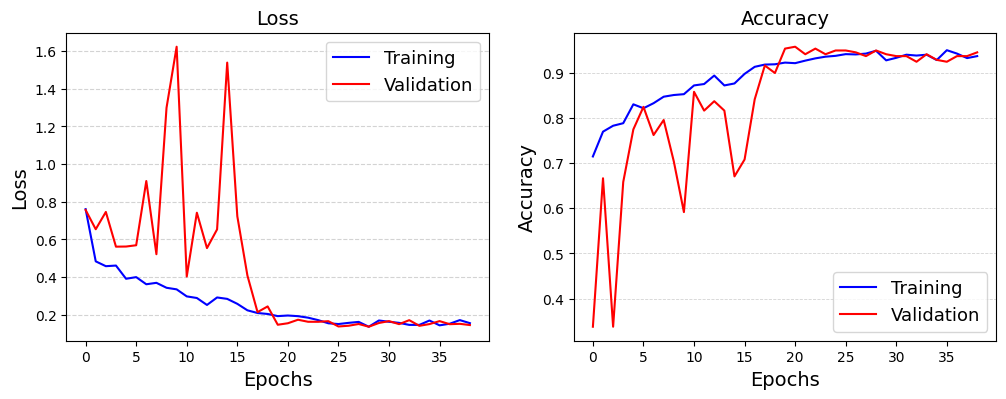

In [ ]:
import matplotlib.pyplot as plt

with open('/content/drive/MyDrive/Final_Project/models/history/1.0-MobileNetV1-224_.json', 'r') as f:
  history = json.load(f)

def plot(history, save_path=None, dpi=300, format='pdf', bbox_inches='tight'):
    plt.figure(figsize=(12, 4))

    fontsize=14
    lw=1.5

    # Grafico della Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training', color='blue', lw=lw)
    plt.plot(history['val_loss'], label='Validation', color='red', lw=lw)
    plt.title('Loss', fontsize=fontsize)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.grid(axis='y', color='lightgray', linestyle='--', lw=0.8)
    plt.legend(fontsize=13)

    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training', color='blue', lw=lw)
    plt.plot(history['val_accuracy'], label='Validation', color='red', lw=lw)
    plt.title('Accuracy', fontsize=fontsize)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.ylabel('Accuracy', fontsize=fontsize)
    plt.grid(axis='y', color='lightgray', linestyle='--', lw=0.6)
    plt.legend(fontsize=13)

    # Mostra o salva il grafico
    if save_path:
        plt.savefig(save_path, dpi=dpi, format=format, bbox_inches=bbox_inches)
        print(f"Figure saved as {save_path}")
    else:
        plt.show()

plot(history, save_path='./models/figures/convergence.pdf')